# Generating Comparitive Baselines for CAMVID with fastai's Dynamic Unet
> Exploring how baselines are being made and where fastai can fit in

- toc: true
- badges: true
- comments: true
- image: images/camvid.png
- category: papers

---

This blog is also a Jupyter notebook available to run from the top down. There will be code snippets that you can then run in any environment. In this section I will be posting what version of `fastai` and `fastcore` I am currently running at the time of writing this:


* `fastai`: 2.0.13

* `fastcore`: 1.0.13
---

Note: this blog is the result of joint efforts between myself and [Juvian](https://forums.fast.ai/u/juvian/summary) on the forums

# CAMVID Benchmarks, Can't We Just Use the Code from Class?

In the [fastai course](course.fast.ai), we are walked through the [CAMVID](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset, semantic segmentation with a car's point of view. Ideally, we would then like to compare our results to the current [state-of-the-art benchmarks](https://paperswithcode.com/sota/semantic-segmentation-on-camvid). 

However! In it's current state, **this cannot be done**. 

Why you might ask? Recently the benchmarks have been adapting a few "weird" changes, as well as making the dataset slightly easier, although comparing against them is not as straightforward as you would hope either (more on this at the end)


## The Metric:

First, the reported metrics are different. Instead of accuracy the Mean Intersection Over Union (mIOU) is reported, as well as individual IOU's per class

## The Number of Classes:
In the original `fastai` version of the dataset, 31 classes are present, with an additional `void` classes that is ignored in the resulting benchmarks. 

Researchers have since changed this class distribution to 11 total classes: Building, Tree, Sky, Car, Sign, Road, Pedestrian, Fence, Pole, Sidewalk, and Cyclist, with one more twelveth `void` class that is again, not taken into account.

This change in classes allows for a higher mIOU being reported without having the rarely-seen classes scew the results, so if you were running mIOU on the class notebooks and getting ~20% and being confused why it doesn't align, this is why!

## The Splits

When we train with fastai, we wind up mixing in the baseline evaluation dataset with the training data! Not something we want at all! The `train`/`validation`/`test` split in most papers tends to be: `367`/`101`/`233`. That is correct, there is two-times as many test images as there are validation.

## The [SegNet](https://github.com/alexgkendall/SegNet-Tutorial) Version

This is a version that has images and labels coming in at a size of 360x480 pixels, which is half the size of what `fastai`'s source dataset is, but has its labels with the 11 classes. What is different paper to paper however is *how* they use the dataset, which can lead to issues. Let's look at the current options and their pros/cons:

## Using the SegNet Dataset:

If we decide to use only this dataset, there is not much room for fastai's tricks (such as progressive resizing and Pre-Sizing). That being said, there are [papers](https://paperswithcode.com/paper/template-based-automatic-search-of-compact) [which](https://paperswithcode.com/paper/template-based-automatic-search-of-compact) use this. If you look on the CAMVID leaderboard however, you'll notice the best model placed at 8th. So what's next?

## Well, what is the SOTA we're comparing against then? 


While below is a benchmark, we can't truly compare against it. However, if we wish to, we will be focusing on the models that have an ImageNet backbone:

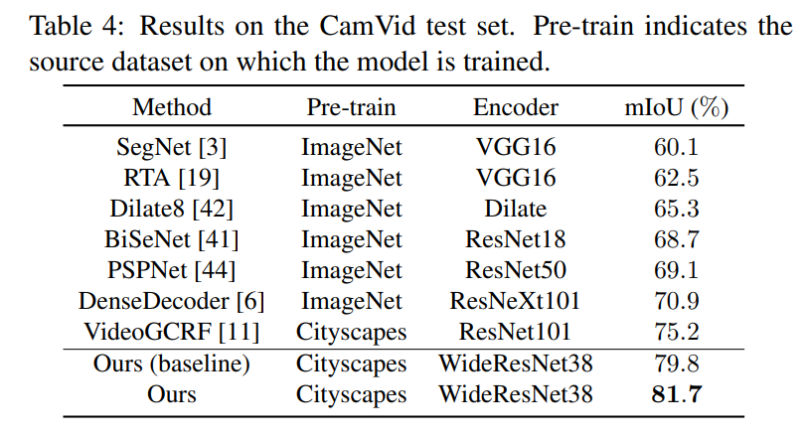


## Using the fastai Images with Smaller Labels

fastai uses the high-quality 720x960 images and labels, so it would make logical sense to train on them and use these smaller masks as the labels, which is being done on all the upper 
benchmarks. 



### The Issue

There is a **very big** issue with this though, which Jeremy pointed out to us while we were discussing these new benchmark approaches. Simply upscaling the labels, without any adjustments to the fastai images, on its own sounds "weird." Instead, what we do is resize the images back *down* to the 360x480 size before then upsampling them. This winds up increasing the final accuracy

# Can We Train Now?

Okay, enough talking, can we see some code to back up your claims? 

Sure, let's do it! To visualize what we will be doing, throughout this blog we will be:

1. Downloading a different dataset
2. Making a `DataBlock` which pre-sizes our images to the proper size
3. Making a `unet_learner` which:
  * Uses a pretrained ResNet34 backbone
  * Uses the `ranger` optimizer function
  * Compare the use of `ReLU` and `Mish` in the head
  * Uses both `IOU` and `mIOU` metrics to properly allow us to benchmark the results
4. Make a `test_dl` with the proper test set to evaluate with.

## Downloading the Dataset

The dataset currently lives in a the repository, so we will go ahead and clone it and make it our working directory:

In [ ]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git
%cd SegNet-Tutorial/

/content/SegNet-Tutorial


Now we still want to use fastai's input images, so we'll go ahead and pull their CAMVID dataset. First let's import fastai's `vision` module:

In [ ]:
from fastai.vision.all import *

Then grab the data:

In [ ]:
path_i = untar_data(URLs.CAMVID)

Let's see how both datasets are formatted:

In [ ]:
path_l = Path('')

In [ ]:
path_i.ls()

(#4) [Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/images'),Path('/root/.fastai/data/camvid/labels'),Path('/root/.fastai/data/camvid/valid.txt')]

In [ ]:
path_l.ls()

(#10) [Path('Example_Models'),Path('.gitignore'),Path('.git'),Path('models'),Path('README.md'),Path('Scripts'),Path('Models'),Path('CamVid'),Path('docker'),Path('.gitattributes')]

So we can see that fastai has the usual `images` and `labels` folder, while we can't quite tell where the annotations are in our second one. Let's narrow down to the `CamVid` folder:

In [ ]:
path_l = path_l/'CamVid'

In [ ]:
path_s.ls()

(#10) [Path('Example_Models'),Path('.gitignore'),Path('.git'),Path('models'),Path('README.md'),Path('Scripts'),Path('Models'),Path('CamVid'),Path('docker'),Path('.gitattributes')]

And we can see a better looking dataset! The three folders we will be caring about are `trainannot`, `valannot` and `testannot`, as these are where the labels live.

## DataBlock

As we saw how the data was split up, fastai currently doesn't have something to work along those lines, the closest is `GrandparentSplitter`. We'll write something similar called `FolderSplitter`, which can accept names for the train and validation folders:

In [ ]:
def _folder_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parents[0].name == name for o in items)
    return [i for n in L(name) for i in _inner(items, n)]

def FolderSplitter(train_name='train', valid_name='valid'):
    "Split `items` from parent folder names `parent_idx` levels above the item"
    def _inner(o):
        return _folder_idxs(o, train_name),_folder_idxs(o, valid_name)
    return _inner

Next we will need a way to get our `x` images, since they live differently than our labels. We can use a custom function to do so:

In [ ]:
def get_x(o): return path_i/'images'/o.name

Finally we need a `get_y` that will use that same filename to go grab our working masks:

In [ ]:
def get_mask(o): return o.parent.parent/(o.parent.name + 'annot')/o.name

We have almost all the pieces to making our dataset now. We'll use fastai's progressive resizing when training, and pass in a set of codes for our dataset:

In [ ]:
codes = ['Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabelled']
half, full = (360, 480), (720, 960)

Now for those transforms. I mentioned earlier we will be downscaling and then upscaling the images, this way the same upscaling is applied to our labels and our images, though the images start from a higher quality. Since we want to train small, we'll resize it back down in the batch transforms as well as normalize our inputs:

In [ ]:
item_tfms = [Resize(half), Resize(full)]
batch_tfms = [*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)]

And with this we can now build the `DataBlock` and `DataLoaders`:

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                   get_items=get_image_files,
                   splitter=FolderSplitter(valid_name='val'),
                   get_x=get_x,
                   get_y=get_mask,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

We'll call the `.summary()` to make sure our images and masks do crop to the half size:

In [ ]:
camvid.summary(path_s)

Setting-up type transforms pipelines
Found 1402 items
2 datasets of sizes 367,101
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_mask -> PILBase.create

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      CamVid/train/0001TP_006720.png
    applying get_x gives
      /root/.fastai/data/camvid/images/0001TP_006720.png
    applying PILBase.create gives
      PILImage mode=RGB size=960x720
  Pipeline: get_mask -> PILBase.create
    starting from
      CamVid/train/0001TP_006720.png
    applying get_mask gives
      CamVid/trainannot/0001TP_006720.png
    applying PILBase.create gives
      PILMask mode=L size=480x360

Final sample: (PILImage mode=RGB size=960x720, PILMask mode=L size=480x360)


Setting up after_item: Pipeline: AddMaskCodes -> Resize -- {'size': (960, 720), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTe

We can see the final input and mask size is (360,480), which is what we want! Let's go ahead and make them `DataLoaders`:

In [ ]:
dls = camvid.dataloaders(path_l, bs=4)

Since we have a `void` column, our `c` attribute in the `DataLoaders` needs to be one less:

In [ ]:
dls.c = len(codes) - 1

## Metrics

For the next part Juvian was the one to bring this to life! We want class-wise `IOU` as well as `mIOU`, which are defined below:

In [ ]:
class IOU(AvgMetric):
    "Intersection over Union Metric"
    def __init__(self, class_index, class_label, axis, ignore_index=-1): store_attr('axis,class_index,class_label,ignore_index')
    def accumulate(self, learn):
        pred, targ = learn.pred.argmax(dim=self.axis), learn.y
        intersec = ((pred == targ) & (targ == self.class_index)).sum().item()
        union = (((pred == self.class_index) | (targ == self.class_index)) & (targ != self.ignore_index)).sum().item()
        if union: self.total += intersec
        self.count += union
  
    @property
    def name(self): return self.class_label

In [ ]:
from sklearn.metrics import confusion_matrix

class MIOU(AvgMetric):
    "Mean Intersection over Union Metric"
    def __init__(self, classes, axis): store_attr()

    def accumulate(self, learn):
        pred, targ = learn.pred.argmax(dim=self.axis).cpu(), learn.y.cpu()
        pred, targ = pred.flatten().numpy(), targ.flatten().numpy()
        self.total += confusion_matrix(targ, pred, range(0, self.classes))

    @property
    def value(self): 
        conf_matrix = self.total
        per_class_TP = np.diagonal(conf_matrix).astype(float)
        per_class_FP = conf_matrix.sum(axis=0) - per_class_TP
        per_class_FN = conf_matrix.sum(axis=1) - per_class_TP
        iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)
        iou_index = np.nan_to_num(iou_index)
        mean_iou_index = (np.mean(iou_index))    

        return mean_iou_index

    @property
    def name(self): return 'miou'

With our metric functions defined, let's combine them all. We'll want a `mIOU`, as well as 11 `IOU` for each class:

In [ ]:
metrics = [MIOU(11, axis=1)]

> Note: we do not need to pass in an `ignore_index` here, as any values larger than 10 get ignored

And now let's declare our `IOU`'s. Since there's so many we'll just make a function instead that relies on our `codes`:

In [ ]:
for x in range(11): metrics.append(IOU(x, codes[x], axis=1, ignore_index=11))

With this we can finally move over to our model and training:

## The Model and Training

For the model we will use a pretrained ResNet34 backbone architecture that has Mish on the head of the Dynamic Unet:

In [ ]:
config = unet_config(self_attention=False, act_cls=Mish)

Our optimizer will be `ranger`:

In [ ]:
opt_func = ranger

And finally, since we have an `ignore_index` we need to pass this into our loss function as well, otherwise we will trigger a `CUDA error: device-side assert triggered`

In [ ]:
loss_func = CrossEntropyLossFlat(ignore_index=11, axis=1)

Now let's pass this all into `unet_learner`:

In [ ]:
learn = unet_learner(dls, resnet34, metrics=metrics, opt_func=opt_func, 
                     loss_func=loss_func, config=config)

### Phase 1

We'll find a good learning rate, fit for ten epochs frozen with `GradientAccumulation` to help with stability before unfreezing and training for a few more:

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0020892962347716093)

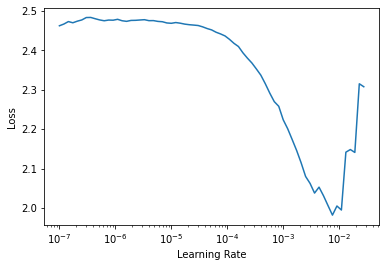

In [ ]:
learn.lr_find()

A good learning rate is around 2e-3, so we'll train with that using `fit_flat_cos` as the `ranger` optimizer should be paired with it:

In [ ]:
lr = 2e-3
learn.fit_flat_cos(10, slice(lr), cbs=[GradientAccumulation(n_acc=16)])

epoch,train_loss,valid_loss,miou,Sky,Building,Pole,Road,Pavement,Tree,SignSymbol,Fence,Car,Pedestrian,Bicyclist,time
0,1.162642,0.830909,0.299915,0.850016,0.720559,0.000000,0.734372,0.005697,0.749899,0.000000,0.000000,0.238510,0.000009,0.000003,00:39
1,0.569644,0.551801,0.398469,0.848527,0.800856,0.000051,0.864739,0.615514,0.764100,0.000006,0.000666,0.488625,0.000070,0.000003,00:37
2,0.387381,0.411216,0.443193,0.918156,0.827368,0.000908,0.921386,0.709569,0.801621,0.005456,0.007531,0.448669,0.232349,0.002113,00:37
3,0.333921,0.326008,0.496475,0.924962,0.840404,0.011554,0.923771,0.718646,0.829867,0.023035,0.202648,0.518755,0.280148,0.187440,00:37
4,0.294099,0.270652,0.607196,0.937552,0.860398,0.034332,0.936088,0.777721,0.876683,0.296792,0.444657,0.802165,0.205760,0.507009,00:37
5,0.272435,0.318103,0.527400,0.939192,0.878254,0.018640,0.933573,0.755946,0.824695,0.140463,0.176000,0.717226,0.206925,0.210483,00:37
6,0.242351,0.255115,0.612202,0.938605,0.851442,0.103728,0.960932,0.807325,0.881588,0.313081,0.306087,0.832003,0.227081,0.512351,00:37
7,0.216592,0.214736,0.645027,0.936698,0.875815,0.102885,0.959163,0.854719,0.878774,0.322827,0.414789,0.833429,0.304491,0.611709,00:37
8,0.191387,0.201309,0.664665,0.945265,0.884462,0.115261,0.962832,0.849719,0.887839,0.448588,0.474916,0.848538,0.303117,0.590774,00:37
9,0.170935,0.189776,0.687851,0.946590,0.888985,0.134946,0.966191,0.868712,0.895303,0.480555,0.510688,0.842302,0.344223,0.687870,00:38


Next we'll unfreeze and train for 12 more epochs. When training we will adjust the learning rate and apply the `EarlyStoppingCallback` to help prevent overfitting:

In [ ]:
lrs = slice(lr/400, lr/4)
learn.unfreeze()
learn.fit_flat_cos(12, lrs, cbs=[GradientAccumulation(n_acc=16)])

epoch,train_loss,valid_loss,miou,Sky,Building,Pole,Road,Pavement,Tree,SignSymbol,Fence,Car,Pedestrian,Bicyclist,time
0,0.170546,0.189820,0.681999,0.947521,0.886054,0.123707,0.963912,0.858991,0.903831,0.472941,0.535916,0.841166,0.329397,0.638557,00:38
1,0.167132,0.185756,0.700118,0.942928,0.886193,0.132603,0.961450,0.852876,0.906680,0.499877,0.569108,0.839536,0.382884,0.727162,00:38
2,0.162575,0.190274,0.689295,0.948446,0.891644,0.152469,0.967852,0.874018,0.887962,0.513959,0.455734,0.824832,0.377302,0.688029,00:38
3,0.154237,0.184436,0.691056,0.948146,0.891873,0.139098,0.969420,0.875096,0.897764,0.433417,0.500059,0.750598,0.455489,0.740658,00:38
4,0.147998,0.193098,0.675041,0.948695,0.890446,0.084957,0.968618,0.869571,0.879427,0.338812,0.431009,0.770100,0.485041,0.758775,00:38
5,0.143527,0.163982,0.722630,0.948684,0.901439,0.152501,0.969498,0.883858,0.911979,0.513825,0.571705,0.828399,0.491902,0.775135,00:38
6,0.137811,0.174498,0.714681,0.944487,0.895405,0.165349,0.968885,0.867411,0.906105,0.525286,0.540363,0.818458,0.450268,0.779475,00:38
7,0.131145,0.179407,0.701152,0.946557,0.897255,0.168435,0.966907,0.864255,0.908184,0.556464,0.556245,0.835180,0.354617,0.658566,00:38
8,0.135147,0.181778,0.715935,0.947702,0.902831,0.156737,0.965431,0.865136,0.884078,0.568458,0.465829,0.836454,0.509690,0.772943,00:38
9,0.130289,0.168858,0.713021,0.948509,0.889958,0.103876,0.969845,0.874681,0.920235,0.512398,0.602391,0.735239,0.519110,0.766987,00:39


We'll save away this model and quickly check how it's doing on our test set:

In [ ]:
learn.save("360")

Path('models/360.pth')

In [ ]:
fnames = get_image_files(path_l/'test')
test_dl = learn.dls.test_dl(fnames, with_labels=True)
metrics = learn.validate(dl=test_dl)[1:]
names = list(map(lambda x: x.name, learn.metrics))
for value, metric in zip(metrics, names):
  print(metric, value)

miou 0.6491944773425827
Sky 0.9239149390135686
Building 0.8259177414811611
Pole 0.24303379912808526
Road 0.9431520033391092
Pavement 0.8287475354267058
Tree 0.7607134277668108
SignSymbol 0.42550575082457764
Fence 0.3664700128429962
Car 0.82235564906033
Pedestrian 0.5225361334962257
Bicyclist 0.47879225838884004


We can see a starting mIOU of 65% almost matching the mid-tier performer, let's see if we can take it further by using the full sized images

### Phase 2:

First let's free up our memory:

In [ ]:
del learn
torch.cuda.empty_cache()
import gc
gc.collect()

9087

We'll adjust our transforms to instead keep our full sized images:

In [ ]:
item_tfms = [Resize(half), Resize(full)]
batch_tfms = [*aug_transforms(size=full), Normalize.from_stats(*imagenet_stats)]

And simply train again from there:

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                   get_items=get_image_files,
                   splitter=FolderSplitter(valid_name='val'),
                   get_x=get_x,
                   get_y=get_mask,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

dls = camvid.dataloaders(path_s, bs=2)
dls.c = len(codes) - 1

We'll need to re-declare our metrics as the current ones have memory of our last training session:

In [ ]:
metrics = [MIOU(11, axis=1)]
for x in range(11): metrics.append(IOU(x, codes[x], axis=1, ignore_index=11))

And now let's train:

In [ ]:
learn = unet_learner(dls, resnet34, metrics=metrics, opt_func=opt_func,
                     config=config, loss_func=loss_func)
learn.load('360');

In [ ]:
learn.freeze()

lr = 1e-3
learn.fine_tune(12, lr, cbs=[GradientAccumulation(n_acc=16), EarlyStoppingCallback()])

epoch,train_loss,valid_loss,miou,Sky,Building,Pole,Road,Pavement,Tree,SignSymbol,Fence,Car,Pedestrian,Bicyclist,time
0,0.196199,0.187521,0.715194,0.945566,0.901315,0.120940,0.948823,0.820386,0.900348,0.573500,0.548016,0.856372,0.504000,0.747869,02:09


epoch,train_loss,valid_loss,miou,Sky,Building,Pole,Road,Pavement,Tree,SignSymbol,Fence,Car,Pedestrian,Bicyclist,time
0,0.171581,0.174548,0.728903,0.947902,0.900998,0.107995,0.951100,0.819368,0.915530,0.590198,0.641584,0.868777,0.506460,0.768022,02:12
1,0.160200,0.173043,0.735925,0.948990,0.901589,0.115515,0.955640,0.838847,0.912397,0.595092,0.630185,0.869995,0.536685,0.790236,02:10
2,0.156472,0.164057,0.740189,0.941088,0.902871,0.100970,0.962597,0.854256,0.912538,0.560043,0.658453,0.859517,0.579467,0.810278,02:09
3,0.145510,0.172418,0.740454,0.947343,0.899524,0.115172,0.961432,0.863362,0.894554,0.623198,0.585500,0.850354,0.581352,0.823206,02:11


No improvement since epoch 2: early stopping


Let's check it's final IOU:

In [ ]:
fnames = get_image_files(path_l/'test')
test_dl = learn.dls.test_dl(fnames, with_labels=True)
metrics = learn.validate(dl=test_dl)[1:]
names = list(map(lambda x: x.name, learn.metrics))
for value, metric in zip(metrics, names):
  print(metric, value)

miou 0.6453756478061708
Sky 0.925848366944526
Building 0.8289784692199771
Pole 0.26388651258934404
Road 0.9011480711241482
Pavement 0.7151582319016668
Tree 0.7667417037925847
SignSymbol 0.4684689773700752
Fence 0.3943911300968112
Car 0.7938686651692142
Pedestrian 0.5653003394554336
Bicyclist 0.4753416582040999


## Results and Discussion

At first we tried a standard Unet without any special tricks, and we got a test mIOU of around 59%. From this baseline we tried applying Self-Attention, Label Smoothing, and the Mish activation function (as the default is ReLU). 

What we found is that by simply applying Mish we could boost that 59% to around 64%, and do note that Mish was only applied to the head of the model, not in the ResNet backbone. (with the highest we got around 67% mIOU)

Self Attention did not seem to help as much, bringing down the mIOU to 62% when training even with the Mish activation function.

Applying Label Smoothing led to a very different result baked inside of each individual IOU. While the mIOU was not as high as a flat Mish model, the distributions of the IOU's changed.

When applying the proper presizing techniques demonstrated here, we saw a boost of 10% mIOU, confirming an idea that simply blowing up your masks to match the original image resolution can diminish the value inside of them.

## Conclusions

What conclusions can we actually make from this study? Not as much as you would think, and the reason lies within current issues in Academia. Right now there are three different datasets being used:

* `fastai` images with `SegNet` masks
* `SegNet` images and masks
* `fastai` images and labels while ignoring all the other classes

Well... who is right then? Technically 2 and 3 are right, but the three cannot be compared equally. Remember that benchmark table I showed earlier? If you go and read the papers each use one of the three techniques done here. 

So... what can we make of this?

There *is* one direct conclusion we can make: using `Mish` in the head of our Dynamic Unet boosts the mIOU by 5%. So it is absolutely worth trying and using with your projects.

## Where do we go from here?

A better dataset which is much more consistant is the [CityScapes](https://www.cityscapes-dataset.com/) dataset. It's for research only and you must upload your predictions on the test set to the website, it's essentially a Kaggle competition for researchers, a format I believe works much better. Researchers compare both how they perform on the validation set and the test set. This is certainly an easier benchmark for folks to tackle with the fastai UNet, so hopefully one day someone will try a benchmark and see how it does!